In [1]:
import random
import itertools
import numpy as np
from copy import deepcopy
from MultiArmBandit import MultiArmBandit

class MonteCarlo(MultiArmBandit):
    def __init__(self,env,discount=1, epsilon=0):
        super().__init__(env,epsilon)
        self._env.reset()
        self._discount = discount
        self._star = deepcopy(self._env._star) # copy env

    def _init_all_states(self):
        """ get all states of the current board
            for each star scenario create one set of states"""
        self._scenarios = {}
        num_star = len(self._env._star)
        index = 0
        for i in range(0,num_star+1):
            for j in list(itertools.combinations(self._env._star,i)):
                if len(j) == 0:
                    self._scenarios[index] = [[]]
                else:
                    self._scenarios[index]  = j
                index += 1
            
        self._all_states = {}
        for i in self._scenarios.keys():
            self._all_states[i] =[]    
            for row in range(self._env._row):
                for col in range(self._env._col):
                    self._all_states[i].append((row, col))

    
    def _init_q_values(self):
        """ initiate q value for all states """
        self._q_values = {}
        
        for scenario in self._all_states.keys():
            values_dict = {}
            for s in self._all_states[scenario]:
                actions = self._env._avaiable_actions(s)

                q_actions = {}
                for action in actions:
                    q_actions[action] = 0

                values_dict[s] = q_actions
            self._q_values[scenario] = values_dict
    
    def _init_action_count(self):
        """ init action count for all states
            this will be same as the init q_value (since defaul 0) """
        
        # check all zeros
        assert sum([x for i in self._q_values.values() for j in i.values() for x in j.values()]) == 0
        
        self._action_counts = deepcopy(self._q_values)
        
    def _get_next_action(self,scenario,loc):
        """ greedy or epsilon greedy search
            if multiple actions found in greedy
            will take randomly              """
        action_list = self._check_avaiable_actions(loc)
        rand = random.random()
        
        if 0 <= rand <= self._epsilon:
            return random.choice(action_list)
        
        else:
            q_list = []
            for action in action_list:
                q_list.append(self._q_values[scenario][(loc)][action])
                
            index = random.choice(np.argwhere(q_list == np.amax(q_list)))[0]

            return action_list[index]    
    
    def _check_scenario(self):
        """ check current scenario """
        current_star = self._env._star
        if len(current_star) == 0:
            return 0
        for scenario,star in self._scenarios.items():
            if current_star == list(star):
                return scenario
            
    
    def _update_q_values(self):
        """ update all qs """
        self._current_discount = self._discount
        G = 0
        
        for t in range(len(self.loc_record) - 1,-1,-1):
                scenario = self.action_record[t][0]
                state = self.action_record[t][1]
                action = self.action_record[t][2]
                r = self.reward_record[t]
                act_count = self._action_counts[scenario][tuple(state)][action]
                G += r*self._current_discount
                old_q = self._q_values[scenario][tuple(state)][action]
                
                new_q = old_q + (1/act_count)*(G-old_q)
                
                self._q_values[scenario][tuple(state)][action] = new_q
                
                self._current_discount *= self._discount
    
    def _run_episode(self):
        """ run episode once """
        self.loc_record = []
        self.reward_record = []
        self.action_record = []
        self._terminal_status = False
        
        self._env._player = self._all_states[0][0] # player start loc
        while not self._terminal_status :
            scenario = self._check_scenario()
            loc = self._env._player
            self.loc_record.append(loc)
            
            action = self._get_next_action(scenario,tuple(loc))
            self.action_record.append([scenario,loc,action])
            self._action_counts[scenario][tuple(loc)][action] += 1
            
            loc_1 = self._apply_action(action,loc)
            self._env._player = loc_1
            
            r = self._env._check_reward(loc_1)
            self.reward_record.append(r)

#             self.render()
            
#         print("steps taken:",len(self.loc_record))
            

    def run_algorithm(self,num_episode = 1):
        
        self._env.reset()
        self._env._star = deepcopy(self._star)
        self._init_all_states()
        self._init_q_values()
        self._init_action_count()

        
        for i in range(num_episode):
            self._env._star = deepcopy(self._star)
            self._run_episode()
            self._update_q_values()

                
    def plot_last_episode(self):
        self._env._star = deepcopy(self._star)
        for loc in self.loc_record:
            self._env._player = loc
            if loc in self._env._star:
                self._env._star.remove(loc)
            self.render()
        self._env._player = self._env._terminal
        self.render()
        
                


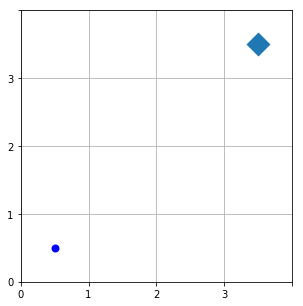

In [2]:
from MazeEnv import MazeGen
%matplotlib inline

maze = MazeGen(4,4)
maze.render()

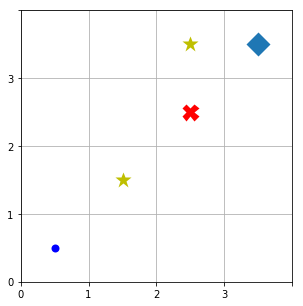

In [3]:
maze.set_grid(star=[1,1])
maze.set_grid(star=[2,3])
maze.set_grid(trap=[2,2])
alg = MonteCarlo(maze,discount = 0.9,epsilon=0.2)
alg.render()

In [4]:
alg.run_algorithm(10000)

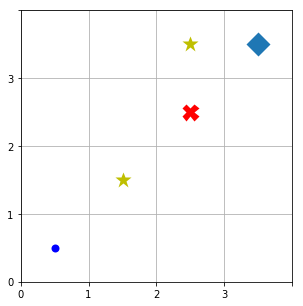

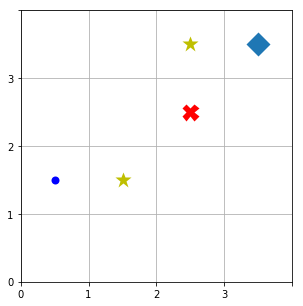

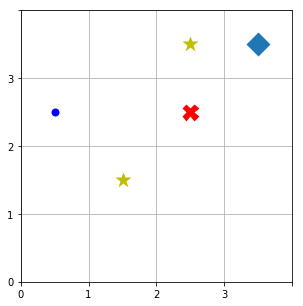

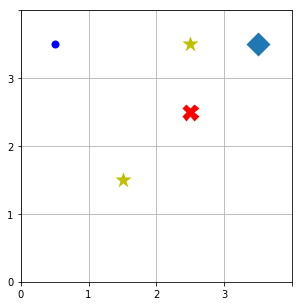

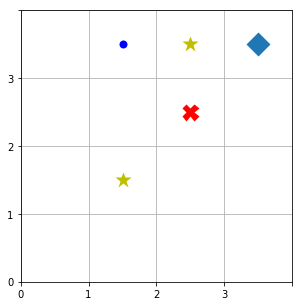

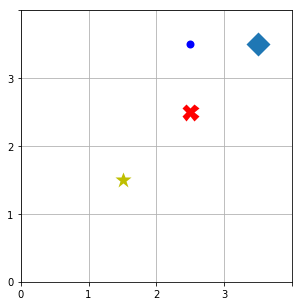

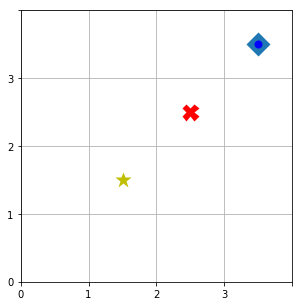

In [5]:
alg.plot_last_episode()

In [6]:
alg._q_values

{0: {(0, 0): {'up': 0, 'right': 74.78929992188998},
  (0, 1): {'up': 79.85067827295283,
   'down': 73.78186425296997,
   'right': 85.62860484326869},
  (0, 2): {'up': 87.6179115,
   'down': 84.2110236319473,
   'right': 85.384001775924},
  (0, 3): {'down': 0, 'right': 88.10130684375},
  (1, 0): {'up': 81.95580038662402,
   'left': 82.01867241093235,
   'right': 84.87345772074845},
  (1, 1): {'up': 70.51109102135999,
   'down': 86.22858694499999,
   'left': 82.426652539443,
   'right': 86.61063866142855},
  (1, 2): {'up': 0,
   'down': 75.76770230099999,
   'left': 85.63119724222157,
   'right': 78.9311475},
  (1, 3): {'down': 85.24405255015364,
   'left': 87.2972262225,
   'right': 88.15664827329486},
  (2, 0): {'up': 85.58433491913705,
   'left': 81.510023450376,
   'right': 83.96278833156379},
  (2, 1): {'up': 81.89999999999999,
   'down': 84.66907624478759,
   'left': 83.62059178508999,
   'right': 87.02659792315605},
  (2, 2): {'up': 85.97942704687499,
   'down': 87.2439345,
   'le